<a href="https://colab.research.google.com/github/stephenbeckr/randomized-algorithm-class/blob/master/Demos/demo_10_05_SLQ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hutchinson trace estimation and Stochastic Lanczos Quadrature

We want to estimate $\text{tr}(B)$ for some matrix $B$. This is trivial if $B$ is given explicitly, but suppose $B$ is given **implicitly** by $B = f(A)$ for some (nice) function $f$.  We interpret $f(A)$ to be in the spectral sense, meaning that we replace the eigenvalues $\lambda$ of $A$ to be $f(\lambda)$.  See [wikipedia](https://en.wikipedia.org/wiki/Analytic_function_of_a_matrix) or N. Higham's book "Functions of matrices theory and computation" (SIAM, 2008).

The Hutchinson trace estimator is just a Monte Carlo estimator using the fact that 
$$
\text{tr}(f(A)) = \mathbb{E} u^T f(A) u
$$
where $u$ is an appropriately distributed random vector (most classically, chosen to be Rademacher).  See Avron and Toledo's ["Randomized algorithms for estimating the trace of an implicit symmetric positive semi-definite matrix"](https://dl.acm.org/doi/10.1145/1944345.1944349) 2011 paper for some analysis (which started a string of papers offering modern analyses).

The next problem is how to compute $u^T f(A) u$ without forming $f(A)$ explicitly. For some functions this is easy, like if $f$ is a polynomial. For example, if $f(t) = t^2$ then $f(A)u = A^2u = A(Au)$ and this is cheap (if you group your parenthesis correctly!).

But what about when $f$ isn't so simple, but is still nice? ("nice" meaning [real analytic](https://en.wikipedia.org/wiki/Analytic_function)).  Common examples include $\log$ (arising since $\text{logdet}(A) = \text{tr}(\log(A))$ ) and $\exp$.  Then we can interpret it as a [Riemann-Stieltjes integral](https://en.wikipedia.org/wiki/Riemann%E2%80%93Stieltjes_integ) and use [Gaussian quadrature](https://en.wikipedia.org/wiki/Gaussian_quadrature). To find the weights and nodes of the Gaussian quadrature rule, it turns out you can use the [Lanczos algorithm](https://en.wikipedia.org/wiki/Lanczos_algorithm).

Our exposition follows ["Fast Estimation of $tr(f(A))$ via Stochastic Lanczos Quadrature"](https://locus.siam.org/doi/abs/10.1137/16M1104974?mobileUi=0) by Ubaru, Chen and Saad in SIMAX 2017.

Demo by Stephen Becker, Oct 2021

In [114]:
import numpy as np
import numpy.linalg
from numpy import trace
from numpy.random import default_rng
rng = default_rng()
import scipy.linalg
from scipy.linalg import expm, norm
from matplotlib import pyplot as plt

### Let's start with a small example to make sure our implementation is correct

In [115]:
N   = 20
A   = rng.standard_normal( (N,N) ) @ np.diag( np.logspace(0,2,N) )
A   = A@A.T  # Need to ensure it is positive semi-definite for theory to hold
A   = A/norm(A,ord=2)  # so that when we take exponential we don't blow up!

print(f"Condition number is {np.linalg.cond(A):.2e}")

Condition number is 3.14e+07


In [116]:
f   = lambda x : np.exp(x) # the scalar function that we'll apply to eigenvalues
B   = expm(A)
trueTrace = trace(B)
print(f"The true trace(exp(A)) is {trueTrace}")

The true trace(exp(A)) is 22.61393002065751


#### Do Hutchinson
We're "cheating" here by explicitly computing $B = f(A)$ first, and then it's easy to compute the matrix-vector product $Bv$.  We'll later relax this, after we've confirmed that this basic version works.

In [117]:
# Hutchinson
nVecs   = int(1e3)
traces  = []
for k in range(nVecs):
  u   = rng.choice( [1,-1], size=N, shuffle=False)
  v   = u/norm(u)
  Av  = B@v
  vAv = v.dot(Av)
  traces.append( N*vAv )

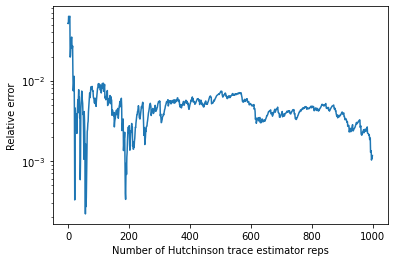

In [118]:
plt.semilogy( np.abs( np.cumsum( traces ) / np.arange(1,nVecs+1) - trueTrace ) / trueTrace )
plt.ylabel('Relative error')
plt.xlabel('Number of Hutchinson trace estimator reps')
plt.show()

#### Now let's compute $v^Tf(A)v$ efficiently using the Lanczos method

The Lanczos method is implemented in `scipy.sparse.linalg.eigsh` but that method is **too fancy** as it does restarts and re-orthogonalizations. These are generally good, but the method needs to be adapted to give us what we want (since we need the fact that our starting vector is $v$, and not just any-old starting vector).

So we can just implement the wikipedia pseudo-code ourselves...

In [119]:
def simpleLanczos( A, v0, m=10):
  """
  Lanczos procedure taken from 
  https://en.wikipedia.org/wiki/Lanczos_algorithm
  Does *not* do restarting or re-orthogonalization or anything fancy
  A should be symmetric pos-semidefinite, and v should be normalized

  Returns eigenvalues and eigenvectors of the tridiagonal matrix T
  formed after m iterations of the Lanczos method.
  """
  alpha = []
  beta  = []
  vNew  = v0.copy()  # we'll overwrite this
  wprime   = A@vNew
  alpha.append( wprime.dot(vNew) )
  w     = wprime - alpha[-1]*vNew
  for j in range(m-1):
    beta.append( norm(w) )
    v   = vNew.copy()
    vNew = w/beta[-1]
    wprime = A@vNew
    alpha.append( wprime.dot(vNew) )
    w     = wprime - alpha[-1]*vNew - beta[-1]*v
  eigVals, eigVecs = scipy.linalg.eigh_tridiagonal( alpha, beta )
  return eigVals, eigVecs

In [127]:
import scipy.sparse.linalg
def GaussianQuadratureViaLanczos( A, f, v, m = 10):
  """
  Gaussian Quadrature using the Lanczos method
  Requires matrix A, function f, starting vector v
    (which must be normalized!)

  Returns Gaussian quadrature approximation of the integral of f(lambda)
  with respect to the weights dmu where dmu is the Riemann-Lebesgue measure
  corresponding to the eigenvalues of A.

  The nodes are at eigVals and the weights are tau**2
  """
  #eigVals, eigVecs = scipy.sparse.linalg.eigsh(A, k=m, v0=v, tol=1e10,maxiter=m)
  # Do NOT use above code.  Use simple code below:
  eigVals, eigVecs = simpleLanczos( A, v0=v, m=m)

  tau = eigVecs[0,:]
  return np.dot( tau**2, f(eigVals) )

#### Let's run it and check if it works

In [121]:
# Hutchinson using Lanczos Quadrature for vAv
nVecs   = 1000
m       = 15  # number of Lanczos vectors
traces  = []
for k in range(nVecs):
  u   = rng.choice( [1,-1], size=N, shuffle=False)
  v   = u/norm(u)
  # Av  = B@v
  # vAv = v.dot(Av)
  vAv = GaussianQuadratureViaLanczos( A, f, v, m = m)
  traces.append( N*vAv )

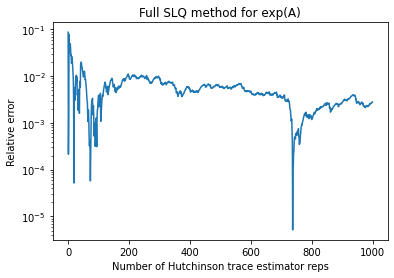

In [122]:
plt.semilogy( np.abs( np.cumsum( traces ) / np.arange(1,nVecs+1) - trueTrace ) / trueTrace )
plt.ylabel('Relative error')
plt.xlabel('Number of Hutchinson trace estimator reps')
plt.title('Full SLQ method for exp(A)')
plt.show()

Not bad, it seems to have worked.

This is a Monte Carlo method, and like all MC methods, we don't expect to quickly get high-accuracy.  The SLQ method is best for quickly getting a low-accuracy solution, i.e., the number of trace estimation repetitions might be on the order of 10.

## Scaling up
That wasn't so impressive for $N=20$. Let's try something bigger

In [123]:
N   = int(3e3)
A   = rng.standard_normal( (N,N) )
A   = A@A.T + np.eye(N)# ensure it is positive semi-definite
A   = A/norm(A,ord=2)  # so that when we take exponential we don't blow up!

print(f"Condition number is {np.linalg.cond(A):.2e}")
f   = lambda x : np.exp(x) # the scalar function that we'll apply to eigenvalues
%time B   = expm(A)
trueTrace = trace(B)  # this is very fast, once we've computed B
print(f"The true trace(exp(A)) is {trueTrace}")

Condition number is 1.20e+04
CPU times: user 31.7 s, sys: 962 ms, total: 32.7 s
Wall time: 16.8 s
The true trace(exp(A)) is 3988.2652337601126


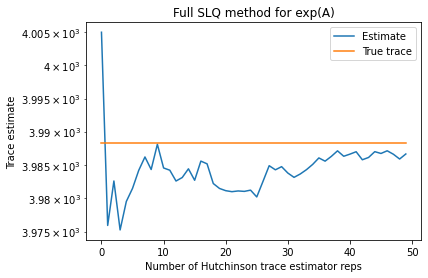

CPU times: user 7.79 s, sys: 370 ms, total: 8.16 s
Wall time: 4.3 s


In [126]:
%%time
# Hutchinson using Lanczos Quadrature for vAv
nVecs   = 50
m       = 15  # number of Lanczos vectors
traces  = []
for k in range(nVecs):
  u   = rng.choice( [1,-1], size=N, shuffle=False)
  v   = u/norm(u)
  vAv = GaussianQuadratureViaLanczos( A, f, v, m = m)
  traces.append( N*vAv )

plt.semilogy( np.cumsum( traces ) / np.arange(1,nVecs+1), label='Estimate' )
plt.semilogy( np.arange(nVecs), trueTrace*np.ones(nVecs), label='True trace' )
plt.legend()
plt.ylabel('Trace estimate')
plt.xlabel('Number of Hutchinson trace estimator reps')
plt.title('Full SLQ method for exp(A)')
plt.show()

... and it seems to have worked!  In this case, for the $3000\times 3000$ matrix, we have a speed benefit (if the accuracy level is acceptable for whatever application).